In [33]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import xgboost as xgb
from datetime import date
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [21]:
data = pd.read_csv('C:/Users/bcspr/OneDrive/Desktop/bigger project/Code/daily_sales.csv')
df = data.copy()
df.drop(columns= 'Unnamed: 0', inplace= True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)


In [22]:
df.head()

,sales,onpromotion,national_holiday
date,,,
2013-01-01,2511.619,0.0,1.0
2013-01-02,496092.418,0.0,0.0
2013-01-03,361461.231,0.0,0.0
2013-01-04,354459.677,0.0,0.0
2013-01-05,477350.121,0.0,1.0


In [41]:
def create_features(df):
    """
        Quick Create of all the datetime features
        
    """
    df['is_open'] = np.where(df['sales'] == 0, 1, 0)
    df['day_of_week'] = df.index.weekday
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    df['week_of_year'] = df['week_of_year'].astype(int)
    return df
df = create_features(df)

In [42]:
def add_lags(df):
    targert_map= df['sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(targert_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(targert_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(targert_map)
    return df
df = add_lags(df)

In [43]:
df.tail()

,sales,onpromotion,national_holiday,is_open,day_of_week,year,month,day_of_year,day_of_month,week_of_year,lag1,lag2,lag3
date,,,,,,,,,,,,,
2017-08-11,826373.722,7.957,1.0,0,4,2017,8,223,11,32,745662.505,734484.205,402631.840
2017-08-12,792630.535,4.664,0.0,0,5,2017,8,224,12,32,714905.919,936339.026,533996.155
2017-08-13,865639.677,5.209,0.0,0,6,2017,8,225,13,32,761826.129,913846.625,564443.173
2017-08-14,760922.406,4.513,0.0,0,0,2017,8,226,14,33,720032.300,694747.162,433042.299
2017-08-15,762661.936,5.951,0.0,0,1,2017,8,227,15,33,718671.651,629475.643,379329.953


In [32]:
df.columns

Index(['sales', 'onpromotion', 'national_holiday', 'is_open', 'day_of_week',
       'year', 'month', 'day_of_year', 'day_of_month', 'week_of_year', 'lag1',
       'lag2', 'lag3'],
      dtype='object')

In [53]:
tss = TimeSeriesSplit(n_splits= 4, test_size= 365*1, gap= 1)
df= df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['onpromotion', 'national_holiday', 'is_open', 'day_of_week',
       'year', 'month', 'day_of_year', 'day_of_month', 'week_of_year', 'lag1',
       'lag2', 'lag3']
    TARGET = 'sales'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor (base_score = .5, booster = 'gbtree',n_estimators = 500, early_stopping_rounds = 50,\
                            objective = 'reg:linear',
                            max_depth = 3,
                            learning_rate = .01)
    reg.fit(X_train,y_train,eval_set = [(X_train,y_train), (X_test, y_test)]  , verbose = 50)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[12:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:370907.02575	validation_1-rmse:497138.29168


[50]	validation_0-rmse:228084.07471	validation_1-rmse:358591.49891
[100]	validation_0-rmse:142067.72148	validation_1-rmse:277051.35312
[150]	validation_0-rmse:90548.51619	validation_1-rmse:229290.78832
[200]	validation_0-rmse:60143.91135	validation_1-rmse:202046.18760
[250]	validation_0-rmse:42375.79559	validation_1-rmse:185656.34835


C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_open'] = np.where(df['sales'] == 0, 1, 0)
C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df.index.weekday
C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

[300]	validation_0-rmse:32497.13517	validation_1-rmse:176068.88168
[350]	validation_0-rmse:27318.09237	validation_1-rmse:170338.96265
[400]	validation_0-rmse:24266.82564	validation_1-rmse:166749.34141
[450]	validation_0-rmse:22269.83375	validation_1-rmse:164496.39955
[499]	validation_0-rmse:20907.61068	validation_1-rmse:163071.28376
[12:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:452596.20553	validation_1-rmse:634209.97370
[50]	validation_0-rmse:283059.94908	validation_1-rmse:443596.76181
[100]	validation_0-rmse:182875.95538	validation_1-rmse:330104.80823
[150]	validation_0-rmse:124572.12394	validation_1-rmse:263887.15079
[200]	validation_0-rmse:91607.53390	validation_1-rmse:225018.53103
[250]	validation_0-rmse:73422.35606	validation_1-rmse:200537.58845
[300]	validation_0-rmse:63405.9

C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_open'] = np.where(df['sales'] == 0, 1, 0)
C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df.index.weekday
C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

[350]	validation_0-rmse:57215.09418	validation_1-rmse:173397.10584
[400]	validation_0-rmse:52151.45634	validation_1-rmse:165891.78765
[450]	validation_0-rmse:48220.30743	validation_1-rmse:162834.03459
[499]	validation_0-rmse:44698.77138	validation_1-rmse:159069.91140
[12:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:528610.68366	validation_1-rmse:794877.98895
[50]	validation_0-rmse:330046.02508	validation_1-rmse:534800.01056
[100]	validation_0-rmse:212878.44872	validation_1-rmse:382949.25066
[150]	validation_0-rmse:144906.52063	validation_1-rmse:295125.07091
[200]	validation_0-rmse:106640.84732	validation_1-rmse:244216.63610
[250]	validation_0-rmse:85291.28046	validation_1-rmse:214306.77826


C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_open'] = np.where(df['sales'] == 0, 1, 0)
C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df.index.weekday
C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

[300]	validation_0-rmse:73439.86204	validation_1-rmse:197192.41277
[350]	validation_0-rmse:66308.17097	validation_1-rmse:186587.14582
[400]	validation_0-rmse:61765.70415	validation_1-rmse:180276.20921
[450]	validation_0-rmse:58889.06187	validation_1-rmse:175088.54424
[499]	validation_0-rmse:56306.51561	validation_1-rmse:173052.24492
[12:42:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:613569.93689	validation_1-rmse:853109.07311
[50]	validation_0-rmse:383194.01658	validation_1-rmse:543673.42750
[100]	validation_0-rmse:247010.50042	validation_1-rmse:356233.92531
[150]	validation_0-rmse:168189.87963	validation_1-rmse:247229.40985
[200]	validation_0-rmse:124758.55364	validation_1-rmse:183101.81911


C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_open'] = np.where(df['sales'] == 0, 1, 0)
C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df.index.weekday
C:\Users\bcspr\AppData\Local\Temp\ipykernel_8952\528788190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

[250]	validation_0-rmse:101269.95640	validation_1-rmse:147756.62434
[300]	validation_0-rmse:88432.56356	validation_1-rmse:127411.27306
[350]	validation_0-rmse:80942.46912	validation_1-rmse:114100.60707
[400]	validation_0-rmse:76508.14065	validation_1-rmse:106845.23390
[450]	validation_0-rmse:73464.48517	validation_1-rmse:102546.12407
[499]	validation_0-rmse:71287.10888	validation_1-rmse:99889.88341


In [54]:
print(f'scores across folds {np.mean(scores):0.4f}')
print(scores)

scores across folds 148768.9207
[163071.28325502988, 159069.91049048456, 173044.60645462744, 99889.8826632489]


In [58]:
FEATURES = ['onpromotion', 'national_holiday', 'is_open', 'day_of_week',
       'year', 'month', 'day_of_year', 'day_of_month', 'week_of_year', 'lag1',
       'lag2', 'lag3']
TARGET = 'sales'

X_all = df[FEATURES]

Y_all = df[TARGET]
reg = xgb.XGBRegressor (base_score = .5, 
                        booster = 'gbtree',
                        n_estimators = 500, 
                        early_stopping_rounds = 50,
                        objective = 'reg:linear',
                        max_depth = 3,
                        learning_rate = .01)

reg.fit(X_all,Y_all, 
        eval_set= [(X_all,Y_all)]
        ,verbose = 50)

[12:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:672735.39273


[50]	validation_0-rmse:419237.18905
[100]	validation_0-rmse:268107.28636
[150]	validation_0-rmse:180833.37181
[200]	validation_0-rmse:132398.98071
[250]	validation_0-rmse:106262.03544
[300]	validation_0-rmse:92147.45123
[350]	validation_0-rmse:84510.79883
[400]	validation_0-rmse:79998.96548
[450]	validation_0-rmse:77116.85647
[499]	validation_0-rmse:75043.41460


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [59]:
df.index.max()

Timestamp('2017-08-15 00:00:00')

In [67]:
future = pd.date_range('2017-08-15', '2018-08-01')
future_df =pd.DataFrame(index= future)
future_df['is_future'] = True
df['is_future'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [68]:
future_w_numbers = df_and_future.query('is_future').copy()

In [73]:
future_w_numbers.to_csv('C:/Users/bcspr/OneDrive/Desktop/bigger project/Dataframes/future_w_numbers')

In [70]:
future_w_numbers['prediction'] = reg.predict(future_w_numbers[FEATURES])

<Axes: >

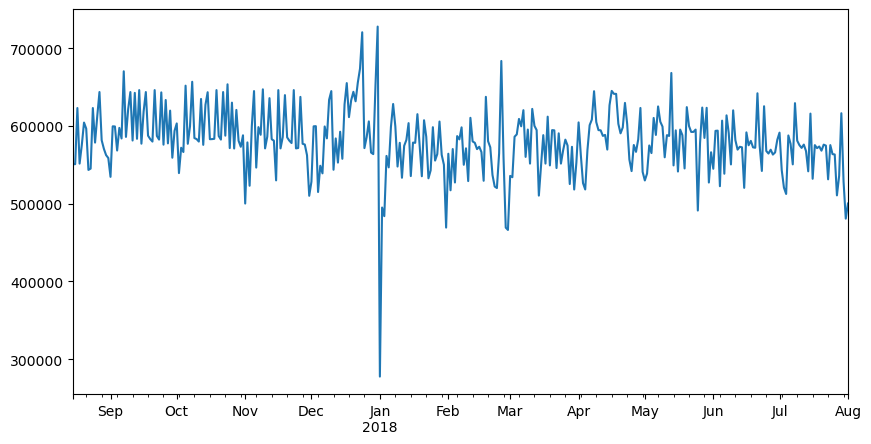

In [71]:
future_w_numbers['prediction'].plot(figsize= (10,5))

In [72]:
reg.save_model('C:/Users/bcspr/OneDrive/Desktop/bigger project/models/training.json')